In [ ]:
import numpy as np 
import pandas as pd
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/dataset/'

archive.zip  assignment3  assignment5  dataset.xlsx  glove.6B.50d.txt


In [ ]:
df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
df.head()

,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
pd.set_option('display.max_colwidth', -1)
df.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,"Girlfight follows a project dwelling New York high school girl from a sense of futility into the world of amateur boxing where she finds self esteem, purpose, and much more. Although the film is not about boxing, boxing is all about the film. So much so you can almost smell the sweat. Technically and artistically a good shoot with an sense of honesty and reality about it, Girlfight is no chick flick and no Rocky. It is, rather, a very human drama which even viewers who don't know boxing will be able to connect with.Girlfight follows a project dwelling New York high school girl from a sense of futility into the world of amateur boxing where she finds self esteem, purpose, and much more.",POS


### Removing urls from the reviews:

In [ ]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()

In [ ]:
df['text'] = df['Text'].apply(clean_str)

In [ ]:
df.head(1)

,URL,Text,Sentiment,text
0,http://www.imdb.com/title/tt0210075/usercomments,"Girlfight follows a project dwelling New York high school girl from a sense of futility into the world of amateur boxing where she finds self esteem, purpose, and much more. Although the film is not about boxing, boxing is all about the film. So much so you can almost smell the sweat. Technically and artistically a good shoot with an sense of honesty and reality about it, Girlfight is no chick flick and no Rocky. It is, rather, a very human drama which even viewers who don't know boxing will be able to connect with.Girlfight follows a project dwelling New York high school girl from a sense of futility into the world of amateur boxing where she finds self esteem, purpose, and much more.",POS,girlfight follows a project dwelling new york high school girl from a sense of futility into the world of amateur boxing where she finds self esteem purpose and much more although the film is not about boxing boxing is all about the film so much so you can almost smell the sweat technically and artistically a good shoot with an sense of honesty and reality about it girlfight is no chick flick and no rocky it is rather a very human drama which even viewers who dont know boxing will be able to connect withgirlfight follows a project dwelling new york high school girl from a sense of futility into the world of amateur boxing where she finds self esteem purpose and much more


In [ ]:
df.Sentiment.value_counts()

NEG    1000
POS    999 
Name: Sentiment, dtype: int64

In [ ]:
df_0 = df[df['Sentiment'] == 'POS'].sample(frac=1)
df_1 = df[df['Sentiment'] == 'NEG'].sample(frac=1)

# we want a balanced set for training against - there are 7072 `0` examples
sample_size = 999

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [ ]:
data.Sentiment.value_counts()

POS    999
NEG    999
Name: Sentiment, dtype: int64

In [ ]:
data['l'] = data['text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 258.6126126126126
max length of sentence: 1843
std dev length of sentence: 180.55756320777132


In [ ]:
sequence_length = 260 # On an average each review has around 260 words

In [ ]:
max_features = 25000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['text'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['Sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("test set size " + str(len(X_test)))

test set size 600


### Glove embedding:

In [ ]:
embeddings_index = {}
f = open('/content/drive/My Drive/dataset/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34724 unique tokens.


In [ ]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)
non_exist_word_count=0
embedding_dim = 50 #Can try 50/100/200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in our tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        non_exist_word_count=non_exist_word_count+1     
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
print('Count for non exist words in dict :',non_exist_word_count)

25001
Count for non exist words in dict : 5489


### CNN

In [ ]:
from tensorflow.python.keras import regularizers

num_filters = 50
inputs_2 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs_2)
reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)
conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(1e-5))(reshape_2)
maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
flatten_2 = Flatten()(maxpool_0_2)
dropout_2 = Dropout(0.5)(flatten_2)
output_2 = Dense(units=2, activation='softmax')(dropout_2)

In [ ]:
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 260)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 260, 50)           1250050   
_________________________________________________________________
reshape (Reshape)            (None, 260, 50, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 1, 50)        7550      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0     

In [ ]:
batch_size = 32
history_2 = model_2.fit(X_train, y_train, epochs=8, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/8
40/40 [==============================] - 2s 40ms/step - loss: 0.5836 - accuracy: 0.6864 - val_loss: 0.3175 - val_accuracy: 0.9214
Epoch 2/8
40/40 [==============================] - 1s 21ms/step - loss: 0.2882 - accuracy: 0.9072 - val_loss: 0.2777 - val_accuracy: 0.9214
Epoch 3/8
40/40 [==============================] - 1s 22ms/step - loss: 0.3161 - accuracy: 0.9022 - val_loss: 0.2830 - val_accuracy: 0.9214
Epoch 4/8
40/40 [==============================] - 1s 22ms/step - loss: 0.2661 - accuracy: 0.9151 - val_loss: 0.2724 - val_accuracy: 0.9214
Epoch 5/8
40/40 [==============================] - 1s 22ms/step - loss: 0.2796 - accuracy: 0.8999 - val_loss: 0.2632 - val_accuracy: 0.9214
Epoch 6/8
40/40 [==============================] - 1s 22ms/step - loss: 0.2259 - accuracy: 0.9368 - val_loss: 0.2555 - val_accuracy: 0.9214
Epoch 7/8
40/40 [==============================] - 1s 22ms/step - loss: 0.2297 - accuracy: 0.9246 - val_loss: 0.2710 - val_accuracy: 0.9214
Epoch 8/8
40/40 [===

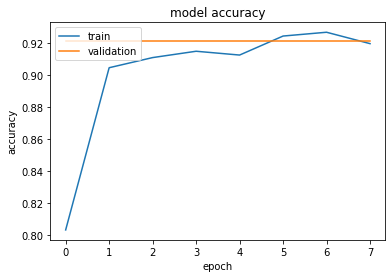

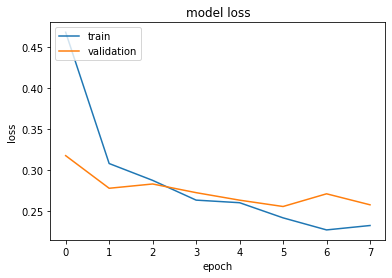

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_2 = model_2.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

0.9366666666666666

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

array([[298,   8],
       [ 30, 264]])

In [ ]:
## Helper Function

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import pickle

def generate_report(pred_list, custom_model, model_name,y_test):
  print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_list)}')
  print(f'\nClassification Report:\n{classification_report(y_test,pred_list)}')
  acc = accuracy_score(y_test, pred_list) * 100
  print(f'Accuracy: {acc}%')
  prec = precision_score(y_test, pred_list, average='macro') * 100
  print(f'Precision: {prec}%')
  rec = recall_score(y_test, pred_list, average='macro') * 100
  print(f'Recall: {rec}%')
  # pickle.dump(custom_model, open(model_name + '.sav', 'wb'))
  print(model_name + ' trained')
  return acc, prec, rec

In [ ]:
cnn_metrics = [None, None, None]
cnn_metrics[0], cnn_metrics[1], cnn_metrics[2] = generate_report(y_hat_2.argmax(axis=1), model_2, 'CNN_model',y_test.argmax(axis=1))

Confusion Matrix:
[[298   8]
 [ 30 264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       306
           1       0.97      0.90      0.93       294

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

Accuracy: 93.66666666666667%
Precision: 93.95624103299856%
Recall: 93.59076964118981%
CNN_model trained


### LSTM model 

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length))
model_lstm.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_lstm.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 260, 50)           1250000   
_________________________________________________________________
lstm (LSTM)                  (None, 260, 256)          314368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 1,774,590
Trainable params: 1,774,590
Non-trainable params: 0
______________________________________________

In [ ]:
# fit
history = model_lstm.fit(X_train, y_train, epochs=4, batch_size=256, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/4
5/5 [==============================] - 57s 10s/step - loss: 0.6998 - accuracy: 0.5170 - val_loss: 0.6912 - val_accuracy: 0.6429
Epoch 2/4
5/5 [==============================] - 52s 11s/step - loss: 0.6619 - accuracy: 0.6633 - val_loss: 2.0437 - val_accuracy: 0.5071
Epoch 3/4
5/5 [==============================] - 48s 10s/step - loss: 1.5903 - accuracy: 0.6142 - val_loss: 0.6604 - val_accuracy: 0.6286
Epoch 4/4
5/5 [==============================] - 48s 10s/step - loss: 0.5740 - accuracy: 0.8115 - val_loss: 0.4940 - val_accuracy: 0.7786


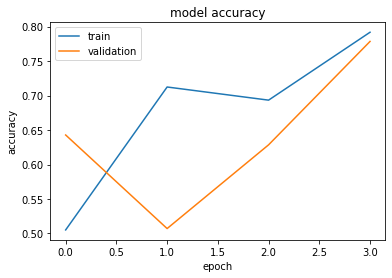

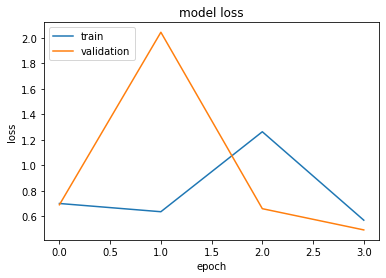

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_6 = model_lstm.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_6)))

0.7716666666666666

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_6)))

array([[208,  98],
       [ 39, 255]])

In [ ]:
lstm_metrics = [None, None, None]
lstm_metrics[0], lstm_metrics[1], lstm_metrics[2] = generate_report(y_hat_2.argmax(axis=1), model_2, 'LSTM_model',y_test.argmax(axis=1))

Confusion Matrix:
[[298   8]
 [ 30 264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       306
           1       0.97      0.90      0.93       294

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

Accuracy: 93.66666666666667%
Precision: 93.95624103299856%
Recall: 93.59076964118981%
LSTM_model trained


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
dt_clf = DecisionTreeClassifier()

# Train the Model
dt_clf.fit(X_train,y_train)   
dt_pred = dt_clf.predict(X_test)

In [ ]:
dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(dt_pred.argmax(axis=1), dt_clf, 'DecisionTree_model',y_test.argmax(axis=1))

Confusion Matrix:
[[200 106]
 [116 178]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       306
           1       0.63      0.61      0.62       294

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.63      0.63      0.63       600

Accuracy: 63.0%
Precision: 62.98359778926725%
Recall: 62.95184740562891%
DecisionTree_model trained


### Bernoulli Naive Bayes:

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb_clf = BernoulliNB()
bnb_clf.fit(X_train,y_train.argmax(axis=1))
BNBpred=bnb_clf.predict(X_test)

In [ ]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(BNBpred, bnb_clf, 'BernoulliNB_model',y_test.argmax(axis=1))

Confusion Matrix:
[[186 120]
 [156 138]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57       306
           1       0.53      0.47      0.50       294

    accuracy                           0.54       600
   macro avg       0.54      0.54      0.54       600
weighted avg       0.54      0.54      0.54       600

Accuracy: 54.0%
Precision: 53.93716850265198%
Recall: 53.86154461784714%
BernoulliNB_model trained


### Multinomial Naive Bayes:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb_clf = MultinomialNB()

#train the model
mnb_clf.fit(X_train,y_train.argmax(axis=1))
MNBpred=mnb_clf.predict(X_test)

In [ ]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(MNBpred, mnb_clf, 'MultinomialNB_model',y_test.argmax(axis=1))

Confusion Matrix:
[[145 161]
 [135 159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       306
           1       0.50      0.54      0.52       294

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.51       600

Accuracy: 50.66666666666667%
Precision: 50.736607142857146%
Recall: 50.73362678404696%
MultinomialNB_model trained


### Maximum Entropy (Logistic Regression):

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_clf = LogisticRegression(max_iter=300)

# Train the Model
lr_clf.fit(X_train,y_train.argmax(axis=1))   
LRpred = lr_clf.predict(X_test)

lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(LRpred, lr_clf, 'LinearRegression_model',y_test.argmax(axis=1))

Confusion Matrix:
[[208  98]
 [127 167]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       306
           1       0.63      0.57      0.60       294

    accuracy                           0.62       600
   macro avg       0.63      0.62      0.62       600
weighted avg       0.63      0.62      0.62       600

Accuracy: 62.5%
Precision: 62.55421008166713%
Recall: 62.388288648792845%
LinearRegression_model trained


### Support Vector Machine:

In [ ]:
from sklearn.svm import SVC
from sklearn import svm

In [ ]:
SVMclassifier = svm.SVC()
SVMclassifier.fit(X_train,y_train.argmax(axis=1))
SVMpred = SVMclassifier.predict(X_test)

In [ ]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(SVMpred, SVMclassifier, 'SVM_model',y_test.argmax(axis=1))

Confusion Matrix:
[[271  35]
 [ 78 216]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       306
           1       0.86      0.73      0.79       294

    accuracy                           0.81       600
   macro avg       0.82      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

Accuracy: 81.16666666666667%
Precision: 81.85310334592862%
Recall: 81.015739629185%
SVM_model trained


### Results comparisons plots and tables:

In [ ]:
!pip3 install tabulate
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'], 
         ['Multinomial Naïve Bayes', mnb_metrics[0], mnb_metrics[1], mnb_metrics[2]], 
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]],
         ['CNN', cnn_metrics[0], cnn_metrics[1], cnn_metrics[2]],
         ['LSTM', lstm_metrics[0], lstm_metrics[1], lstm_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name              │   Accuracy │   Precision │   Recall │
╞═════════════════════════╪════════════╪═════════════╪══════════╡
│ Multinomial Naïve Bayes │    50.6667 │     50.7366 │  50.7336 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Bernoulli Naïve Bayes   │    54      │     53.9372 │  53.8615 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine  │    81.1667 │     81.8531 │  81.0157 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy         │    62.5    │     62.5542 │  62.3883 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree           │    63      │     62.9836 │  62.9518 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ CNN                     │    93.6667 │     93.9562 │  93.5908 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ LSTM    

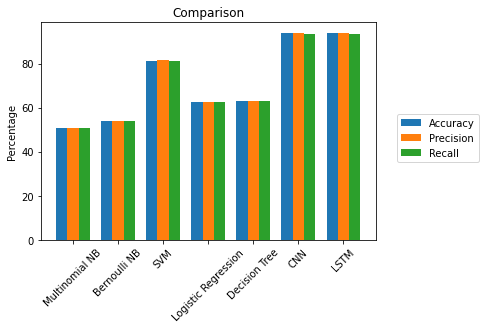

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 7
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0], cnn_metrics[0], lstm_metrics[0]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1], cnn_metrics[1], lstm_metrics[1]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2], cnn_metrics[2], lstm_metrics[2]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree', 'CNN', 'LSTM'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()

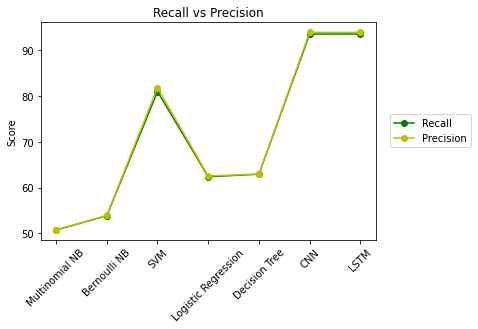

In [ ]:
import matplotlib.pyplot as plt
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree', 'CNN', 'LSTM']
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2], cnn_metrics[2], lstm_metrics[2]]
precision = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1], cnn_metrics[1], lstm_metrics[1]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()